# Project Description:

## INTRODUCTION 

### Goal: Predicting the age, gender and race from a face image. 

#### Data Sources: UTKFace Dataset 

- Found at: https://susanqq.github.io/UTKFace/
- Downloaded UTKFace.tar.gz from: https://drive.google.com/drive/folders/0BxYys69jI14kU0I1YUQyY1ZDRUE


#### Dataset Description:

 - Consists of 23708 aligned and cropped images
 - Labels of the picture are the filename of the picture given in the format of age_gender_race_timestamp.jpg
 - age has a number between 0 and 116
 - gender: male-->0; female-->1
 - race: White-->0; Black-->1; Asian-->2; Indian-->3; Hispanic/Latino/MiddleEast-->5


### Note: The project was tried on our local machine which has a GPU of 6GB 
- We chose to do so because we can run our code for long hours and we need not have to reconnect to the session

In [1]:
# Importing all the required libraries

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torch import optim
from torchvision import transforms
from torch.autograd import Variable

from torch.utils.data import Dataset, DataLoader
import torchvision.datasets as datasets

from tqdm.autonotebook import tqdm

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

import random
random.seed(123)


import cv2
from torch.autograd import Variable

from PIL import Image
import pandas as pd
import os
import glob
import pickle

from sklearn.metrics import accuracy_score

import time

#### Loading Dataset

In [2]:
# Getting current working directory to get back to this directory easily
cwd=os.getcwd()
images_path='C:\\Users\\jimev\\Desktop\\DeepLearning\\MyProject\\data\\'

Image files had the format xx_xx_xx_xxxxxxx.jpg.chip.jpg

So decided to curtail the .chip.jpg and take .jpg alone.

Here we traditional tried for loop but got enhanced results using lambda
- Using for loop --> 18 sec
- Lamba --> 0.05 (Learnt using lambda efficiently)

In [3]:
## Efficient way of getting my results. Happy in learning something here.

os.chdir(images_path)
start = time.time()
map(lambda filename: filename.split('.')[0]+'.jpg', os.listdir(images_path))
elapsed_time_fl = (time.time() - start)
print('Time take to change the names of all the files: ', elapsed_time_fl)
#os.listdir(images_path)

Time take to change the names of all the files:  0.047922611236572266


In [4]:
# Getting back to the original cwd
os.chdir(cwd)

#### Understanding the dataset
- Exploring the set of images that we have acquired
- We decided to take them as a dataframe to understand the spread better


In [5]:
# This function is to return the key of the inputed value, since there are three different dictionaries that I created
# I chose to write a function which can easily give me the corresponding key 

def get_value(dictionary, this_key): 
    '''
    Gives the value of a inputed key
    dictionary: Dictionary from where the key has to be searched
    this_key: key for which value is required
    '''
    for key, value in dictionary.items(): 
         if this_key==key: 
            return value 
def get_key(dictionary, this_value): 
    '''
    Gives the key of a inputed value
    dictionary: Dictionary from where the key has to be searched
    this_value: value for which key is required
    '''
    for key, value in dictionary.items(): 
         if this_value == value: 
                return key
        

gender_dict={0:'Male', 1:'Female'}
gender_map = dict((g, i) for i, g in gender_dict.items())
race_dict={0: 'White', 1: 'Black', 2: 'Asian', 3: 'Indian', 4: 'Others'}
race_map=dict((r, i) for i, r in race_dict.items())
        


In [6]:
def parse_filepath(filepath):
    '''
    This function is to parse the filepath into three labels age, gender and race
    '''
    try:
        path, filename = os.path.split(filepath)
        filename, ext = os.path.splitext(filename)
        age, gender, race, _ = filename.split("_")
        return int(age), gender_dict[int(gender)], race_dict[int(race)]
    except Exception as e:
        print(filepath)
        return None, None, None

In [7]:
files = glob.glob(os.path.join(images_path, "*.jpg"))
attributes = list(map(parse_filepath, files))

#### Three files with missing Race Label: 

C:\Users\jimev\Desktop\DeepLearning\MyProject\data\39_1_20170116174525125.jpg
C:\Users\jimev\Desktop\DeepLearning\MyProject\data\61_1_20170109142408075.jpg
C:\Users\jimev\Desktop\DeepLearning\MyProject\data\61_1_20170109150557335.jpg

#### So I have manually changed them the following file names:

- 39_1_20170116174525125.jpg --> 39_1_1_20170116174525125.jpg
- 61_1_20170109142408075.jpg --> 61_1_1_20170109142408075.jpg
- 61_1_20170109150557335.jpg --> 61_1_3_20170109150557335.jpg

In [8]:
df = pd.DataFrame(attributes)
df['file'] = files
df.columns = ['age', 'gender', 'race', 'file']
df = df.dropna()
df.head()

,age,gender,race,file
0,100,Male,White,C:\Users\jimev\Desktop\DeepLearning\MyProject\...
1,100,Male,White,C:\Users\jimev\Desktop\DeepLearning\MyProject\...
2,100,Female,White,C:\Users\jimev\Desktop\DeepLearning\MyProject\...
3,100,Female,White,C:\Users\jimev\Desktop\DeepLearning\MyProject\...
4,100,Female,White,C:\Users\jimev\Desktop\DeepLearning\MyProject\...


In [9]:
df.shape

(23708, 4)

In [10]:
def label (plot):
    
    '''
    This function labels my count plots effectively
    '''
    for rect in plot.patches:
        # Get X and Y placement of label from rect.
        y_value = rect.get_height()
        x_value = rect.get_x() + rect.get_width() / 2

        # Number of points between bar and label. Change to your liking.
        space = 5
        # Vertical alignment for positive values
        va = 'bottom'

        # If value of bar is negative: Place label below bar
        if y_value < 0:
            # Invert space to place label below
            space *= -1
            # Vertically align label at top
            va = 'top'
            # Use Y value as label and format number with one decimal place
        label = "{:.1f}".format(y_value)

            # Create annotation
        plot.annotate(
            label,                      # Use `label` as label
            (x_value, y_value),         # Place label at end of the bar
            xytext=(0, space),          # Vertically shift label by `space`
            textcoords="offset points", # Interpret `xytext` as offset in points
            ha='center',                # Horizontally center label
            va=va)                      # Vertically align label differently for
                                            # positive and negative values.
    plt.show()
sns.set(style="ticks", color_codes=True)   

#### Understanding spread using plots

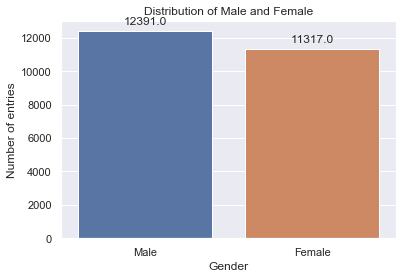

In [11]:
## Plot 1 --> Frequency of Gender

sns.set(rc={'figure.figsize':(6,4)})
plot = sns.countplot(x='gender', data = df)
plot.set_title('Distribution of Male and Female')
plot.set_xlabel('Gender')
plot.set_ylabel('Number of entries')
label(plot)

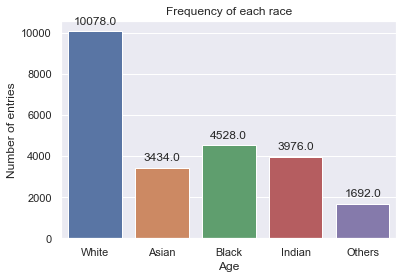

In [12]:
# Plot 2 --> Frequency of Races
sns.set(rc={'figure.figsize':(6,4)})
plot = sns.countplot(x='race', data = df)
plot.set_title('Frequency of each race')
plot.set_xlabel('Age')
plot.set_ylabel('Number of entries')
label(plot)

# Double click the image to view an enlarged plot

#### According to plot above, most of our results may be biased to white

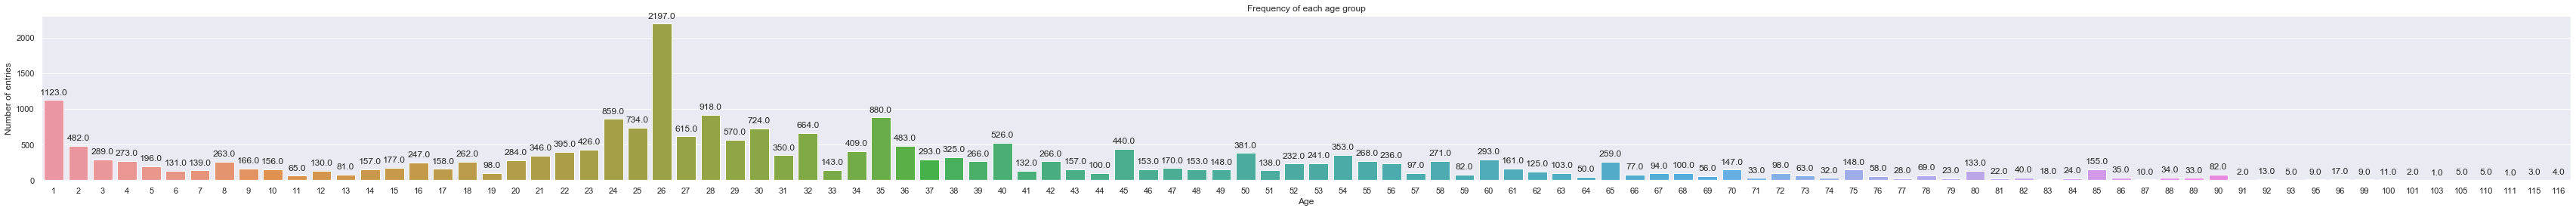

In [13]:
# Plot 3 --> Frequency of Ages
sns.set(rc={'figure.figsize':(60,4)})
plot = sns.countplot(x='age', data = df)
plot.set_title('Frequency of each age group')
plot.set_xlabel('Age')
plot.set_ylabel('Number of entries')
label(plot)

# Double click the image to view an enlarged plot

 Looking at the distribution we have decided to divide the files into age classes such as -->
- 00-05 --> 0
- 06-10 --> 1
- 11-15 --> 2
- 16-20 --> 3
- 21-30 --> 4
- 31-40 --> 5
- 41-50 --> 6
- 51-60 --> 7
- 61-70 --> 8
- 70+ --> 9


In [14]:
def age_label(age_value):
    '''
    age_value: Age is taken as input to give a class from 0 - 9 according to the above cell
    '''
    if 0 <= age_value <= 5:
        age_value = 0
    elif 6 <= age_value <= 10:
        age_value = 1
    elif 11 <= age_value <= 15:
        age_value = 2
    elif 16 <= age_value <= 20:
        age_value = 3
    elif 21 <= age_value <= 30:
        age_value = 4
    elif 31 <= age_value <= 40:
        age_value = 5
    elif 41 <= age_value <= 50:
        age_value = 6
    elif 51 <= age_value <= 60:
        age_value = 7
    elif 61 <= age_value <= 70:
        age_value = 8
    else:
        age_value = 9
    return str(age_value)


Process followed to read the data
 - Listed all the filenames from the data folder
 - Randomised the images
 - Saved filenames into a text file
 - Saved labels into another text file spliting the data by '_'
 - Now, saved filenames into two different text files (train, test)
 - Saved filenames into two different text files (train_labels, test_labels)
 

In [15]:
# Function to write the contents to file
def writeToFile(contents, file):
    '''
    Writes contents of a given variable into the given filename
    contents: contents to be written into the file
    file: Name of the file that you would want to write the contents    
    '''
    with open(file, 'w') as f:
        for item in contents:
            f.write(item+'\n')

In [16]:
# function to split the label and store it in a file
def labelsToFile(labels, file):
    '''
    Writes contents of a given variable into the given filename
    contents: contents to be written into the file
    file: Name of the file that you would want to write the contents 
    '''
    with open(file, 'w') as f:
        for item in labels:
            temp_list=item.split('_')
            
            temp_list[0]=age_label(int(temp_list[0])) # New label for age
            # Ex: 25_1_3_xxxxx.jpg --> '413' is written [25 --> 4]
            f.write(temp_list[0]+temp_list[1]+temp_list[2]+'\n')

- We have a multiclass-multioutput problem
- Age(0-9) --> 10 labels, Gender(0-1) --> 2 labels, Race(0-4) --> 5 labels 
- Total: 100 outputs
- Here to eliminate multi-output problem and point it to a single target variable, we have taken new labelling from 0-99 and have given the newlabelling the following way:
  - Permutaions from 000 - 914
  - Each class is replaced and given an integer in a sequence from 0 - 99
  - Ex: label-->'413', new_label--> 48,


In [17]:
## This code permutates and creates a new_dictionary with the old_lables as keys and new_labels as values
count=0
classes_dict={}
for i in range(10):
    for j in range(2):
        for k in range(5):
            #print(str(i)+str(j)+str(k)+':'+str(count))
            classes_dict.update({(str(i)+str(j)+str(k)+'\n'):count})
            count+=1
            

In [18]:
def final_labels(read_from, write_to):
    '''
    Reads label from a file and write new labels into another file
    read_from: File from which labels are to be read
    write_to: File to which the labels are to be written
    '''
    with open(read_from, 'r') as f:    
        with open(write_to, 'w') as f1:
            for line in f:
                f1.write(str(get_value(classes_dict, line))+'\n')

In [19]:
## All the dictionaries
age_dict={'0':'0-5', '1':'6-10', '2':'11-15', '3':'16-20', '4': '21-30', 
          '5':'31-40', '6':'41-50', '7':'51-60', '8':'61-70', '9': '70+'}
gender_dict={'0':'Male', '1':'Female'}
race_dict={'0':'White', '1':'Black', '2':'Asian', '3':'Indian', '4': 'Hispanic/Latino/Middle Eastern'}

In [20]:
## Processed followed, described above
filenames=os.listdir(images_path)
random.shuffle(filenames)
# Divided 80% of files to train, 20% to test
train=filenames[:int(len(filenames)*0.35)]
test=filenames[(int(len(filenames)*0.35)+1) : (int(len(filenames)*0.35)+int(len(filenames)*0.085))]
val=filenames[(int(len(filenames)*0.35)+int(len(filenames)*0.085))+1:(int(len(filenames)*0.35)+int(len(filenames)*0.085))+1001]

In [21]:
# Training image list and the Label list for each image
writeToFile(train, 'train_data.txt')
labelsToFile(train, 'train_labels.txt')

# Testing image list and the Label list for each image
writeToFile(test, 'test_data.txt')
labelsToFile(test, 'test_labels.txt')

# Validation image list and the label list for each image
#writeToFile(val, 'val_data.txt')
#labelsToFile(val, 'val_labels.txt')

final_labels('train_labels.txt', 'final_train.txt')
final_labels('test_labels.txt', 'final_test.txt')


#### Now that we have trainimages filesnames, trainimages labels, testimages filesnames, testimages labels, we shall prepare our Datasets

#### Since this is some unique style of having label data and image data, we have to create a customized dataset


#### Learnt a lot in this area, since we were always dealing with the datasets which were already built, 
#### but it was fun creating a new customized dataset
 - Major Reference: https://github.com/jiangqy/Customized-DataLoader-pytorch/blob/master/dataset_processing.py

In [22]:
####  Editing My DataLoader
class MyDataset(Dataset):
    
    def __init__(self, data_path, img_path, img_filename, label_filename, transform=None):
        
        '''
        data_path: path of the cwd, useful to get back to cwd
        image_path: path of images data folder
        image_filename: file containing filenames of images
        label_filename: file containing filenames of labels
        '''
        self.img_path = os.path.join(data_path, img_path)
        self.transform = transform
        self.train = train
        
        # reading img file from file
        img_filepath = os.path.join(data_path, img_filename)
        fp = open(img_filepath, 'r')
        self.img_filename = [x.strip() for x in fp]
        fp.close()
        # reading labels from file
        label_filepath = os.path.join(data_path, label_filename)
        fp = open(label_filepath, 'r')
        labels = [x.strip() for x in fp]
        labels= list(map(lambda el:int(el), labels))
        #print(labels)
        fp.close()
        #labels = np.loadtxt(label_filepath)
        #labels = np.array(list(map(lambda el:[el], labels)))
        #print (labels)
        #print(type(labels))
        self.label = labels

    def __getitem__(self, index):
        img = Image.open(os.path.join(self.img_path, self.img_filename[index]))
        img = img.convert('RGB')
        if self.transform is not None:
            img = self.transform(img)
      
        label=self.label[index]
        
        return img, label
    def __len__(self):
        return len(self.img_filename)

#### Loading Torch Datasets

In [23]:
# cwd
data_path=os.getcwd()
# image data folder location
image_path=images_path

train_images='train_data.txt'
train_labels='final_train.txt'

test_images='test_data.txt'
test_labels='final_test.txt'

# Total output labels
num_labels=100

# batch size
batch_size=32

In [24]:
# Specify transforms using torchvision.transforms as transforms
# library
train_transformations = transforms.Compose([
    transforms.Resize(128),
    transforms.CenterCrop(128),
    transforms.RandomHorizontalFlip(128),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Test transformations does not need to have RandomHorizontal flip
test_transformations = transforms.Compose([
    transforms.Resize(128),
    transforms.CenterCrop(128),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [25]:
# Loader
train_dataset=MyDataset(data_path, image_path, train_images, train_labels, transform=train_transformations)
test_dataset=MyDataset(data_path, image_path, test_images, test_labels, transform=test_transformations)

In [26]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size= 32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size= 32, shuffle=True)

#### Looking at random sample data with labels

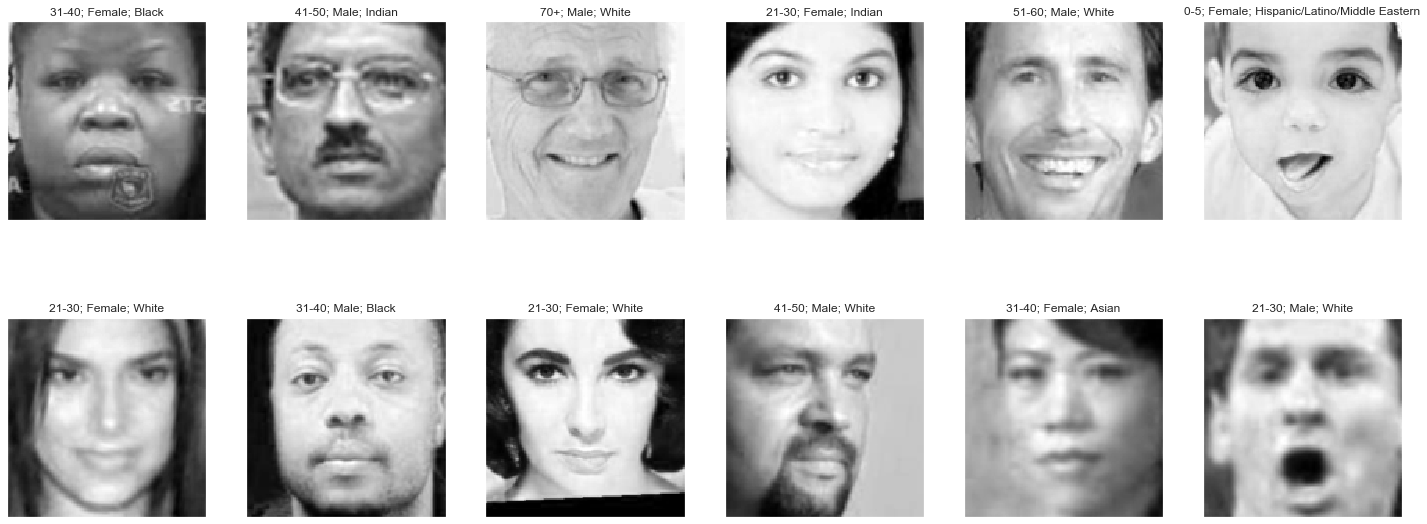

In [27]:
dataiter = iter(train_loader)
images, labels = dataiter.next()
# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 10))
plot_size=12
for idx in np.arange(plot_size):
    ax = fig.add_subplot(2, plot_size/2, idx+1, xticks=[], yticks=[])
    ax.imshow(images[idx][0], cmap='gray')
    # print out the correct label for each image
    # .item() gets the value contained in a Tensor
    temp=list(get_key(classes_dict, int(labels[idx].item())))
    ax.set_title(get_value(age_dict, temp[0])+'; '+ get_value(gender_dict, temp[1])+'; '+ get_value(race_dict, temp[2]))

    # ax.set_title(get_value(age_dict, str(labels[idx, 0:1].item()))+'; '+
   #              get_value(gender_dict, str(labels[idx, 1:2].item()))+'; '+
   #              get_value(race_dict, str(labels[idx, 2:3].item())))
    #ax.set_title(str(labels[idx, 1:2].item()))
    #ax.set_title(str(labels[idx, 2:3].item()))

### Below is the code to train_network
#### Reference: Lecture Notes

In [28]:
def moveTo(obj, device):
    '''
    Function moved the obj to the availble device--> either cpu or cuda
    obj: object
    device: cpu or gpu
    '''
    if isinstance(obj, tuple):
        return tuple([moveTo(x, device) for x in obj])
    elif isinstance(obj, list):
        return [moveTo(x, device) for x in obj]
    elif isinstance(obj, torch.Tensor):
        return obj.to(device)
    else:
        return x

In [29]:
def train_network(model, loss_func, train_loader, val_loader=None, score_funcs=None, 
                         epochs=50, device="cpu", checkpoint_file=None, 
                         lr_schedule=None, optimizer=None, disable_tqdm=False
                        ):
    """Train simple neural networks
    
    Keyword arguments:
    model -- the PyTorch model / "Module" to train
    loss_func -- the loss function that takes in batch in two arguments, the model outputs and the labels, and returns a score
    train_loader -- PyTorch DataLoader object that returns tuples of (input, label) pairs. 
    val_loader -- Optional PyTorch DataLoader to evaluate on after every epoch
    score_funcs -- A dictionary of scoring functions to use to evalue the performance of the model
    epochs -- the number of training epochs to perform
    device -- the compute lodation to perform training
    
    """
    if score_funcs == None:
        score_funcs = {}#Empty set 
    
    to_track = ["epoch", "total time", "train loss"]
    if val_loader is not None:
        to_track.append("val loss")
    for eval_score in score_funcs:
        to_track.append("train " + eval_score )
        if val_loader is not None:
            to_track.append("val " + eval_score )
        
    total_train_time = 0 #How long have we spent in the training loop? 
    results = {}
    #Initialize every item with an empty list
    for item in to_track:
        results[item] = []

        
    if optimizer == None:
        #The AdamW optimizer is a good default optimizer
        optimizer = torch.optim.AdamW(model.parameters())
        del_opt = True
    else:
        del_opt = False

    #Place the model on the correct compute resource (CPU or GPU)
    model.to(device)
    for epoch in tqdm(range(epochs), desc="Epoch", disable=disable_tqdm):
    
        model = model.train()#Put our model in training mode
        running_loss = 0.0
        
        y_true = []
        y_pred = []

        start = time.time()
        for inputs, labels in tqdm(train_loader, desc="Train Batch", leave=False, disable=disable_tqdm):
      
            #Move the batch to the device we are using. 
            inputs = moveTo(inputs, device)
            labels = moveTo(labels, device)
            
            batch_size = labels.shape[0]

            # PyTorch stores gradients in a mutable data structure. So we need to set it to a clean state before we use it. 
            #Otherwise, it will have old information from a previous iteration
            optimizer.zero_grad()

            y_hat = model(inputs) #this just computed f_Θ(x(i))

            # Compute loss.
            loss = loss_func(y_hat, labels)

            loss.backward()# ∇_Θ just got computed by this one call!

            #Now we just need to update all the parameters! 
            optimizer.step()# Θ_{k+1} = Θ_k − η * ∇_Θ ℓ(y_hat, y)

            #Now we are just grabbing some information we would like to have
            running_loss += loss.item() * batch_size
            
            if len(score_funcs) > 0:
                #moving labels & predictions back to CPU for computing / storing predictions
                labels = labels.detach().cpu().numpy()
                y_hat = y_hat.detach().cpu().numpy()
                for i in range(batch_size):
                    y_true.append(labels[i])
                    y_pred.append(y_hat[i,:])
        #end training epoch
        end = time.time()
        total_train_time += (end-start)
        
        results["epoch"].append( epoch )
        results["total time"].append( total_train_time )
        results["train loss"].append( running_loss )
        
        y_pred = np.asarray(y_pred)
        
        if len(y_pred.shape) == 2 and y_pred.shape[1] > 1: #We have a classification problem, convert to labels
            y_pred = np.argmax(y_pred, axis=1)
            
        for name, score_func in score_funcs.items():
            results["train " + name].append( score_func(y_true, y_pred) )
      
        if val_loader is None:
            pass
        else:#Lets find out validation performance as we go!
            model = model.eval() #Set the model to "evaluation" mode, b/c we don't want to make any updates!

            y_true = []
            y_pred = []
            
            val_running_loss = 0.0

            for inputs, labels in val_loader:
        
                #Move the batch to the device we are using. 
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                batch_size = labels.shape[0]
        
                y_hat = model(inputs)
            
                loss = loss_func(y_hat, labels)
                
                #Now we are just grabbing some information we would like to have
                val_running_loss += loss.item() * batch_size

                if len(score_funcs) > 0:
                    #moving labels & predictions back to CPU for computing / storing predictions
                    labels = labels.detach().cpu().numpy()
                    y_hat = y_hat.detach().cpu().numpy()
                    for i in range(batch_size):
                        y_true.append(labels[i])
                        y_pred.append(y_hat[i,:])
                        
            results["val loss"].append( running_loss )

            y_pred = np.asarray(y_pred)

            if len(y_pred.shape) == 2 and y_pred.shape[1] > 1: #We have a classification problem, convert to labels
                y_pred = np.argmax(y_pred, axis=1)

            for name, score_func in score_funcs.items():
                results["val " + name].append( score_func(y_true, y_pred) )
        
        #In PyTorch, the convention is to update the learning rate after every epoch
        if not lr_schedule is None:
            if isinstance(lr_schedule, torch.optim.lr_scheduler.ReduceLROnPlateau):
                lr_schedule.step(val_running_loss)
            else:
                lr_schedule.step()
        
        if checkpoint_file is not None:
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'results' : results
                }, checkpoint_file)
    if del_opt:
        del optimizer

    return pd.DataFrame.from_dict(results)

In [30]:
### Flatten class referenced from lectures notes
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)

In [31]:
# Loss Function
loss_func=nn.CrossEntropyLoss()

In [32]:
# device to be chosen
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

####  A Simple CNN

In [33]:
#Dimension of images--> 128 * 128 
D = 128*128  
#Number of channels in the input-->3
C = 3
#Number of classes in the input-->100
classes = 100

#A simple convolutional network:
model_simple_cnn = nn.Sequential(
  #Conv2d follows the pattern of:
  #Conv2d(# of input channels, #filters/output-channels, #filter-size)
  #For the manditory arguments. 
  nn.Conv2d(C, 32, (3,3), padding=1), 
  #We have to tell pyTorch exactly how many pixels to pad by. 
  #To get 'same' style padding, we want padding=floor(filter-size/2)
  nn.Tanh(),
  Flatten(), #Convert from (B, C, H, W) ->(B, D). This way we can use a Linear layer after
  nn.Linear(32*D, classes),
)

In [34]:
simple_cnn_results = train_network(model_simple_cnn, loss_func, train_loader, val_loader=test_loader, 
                                   score_funcs={'Accuracy': accuracy_score}, device=device, epochs=10)

#### Saving the model and the results into current working directing to avoid executing the model again 

In [35]:
simple_cnn_results.to_csv('simple_cnn_results.csv')
torch.save(model_simple_cnn, 'simple_cnn.pt')

#### We have a model ready. We shall now predict the data giving some random images

In [36]:
def model_cpu(obj):
    return obj.cpu().eval()

In [37]:
def predict_labels(model, imagepath):
    
    '''
    Returns index of the predicted image
    imagepath: Imagefile path
    '''
    print("Prediction in progress")
    image = Image.open(imagepath)
    
    transformations = transforms.Compose([
    transforms.Resize(128),
    transforms.CenterCrop(128),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    # Preprocess the image
    image_tensor = transformations(image).float()
    #image=image_tensor
    
    # Add an extra batch dimension since pytorch treats all images as batches
    image_tensor = image_tensor.unsqueeze_(0)
    
    if torch.cuda.is_available():
        image_tensor.cuda()
        
    # Turn the input into a Variable
    input = Variable(image_tensor)
    
    # Predict the class of the image
    output = model(input)
    
    index = output.data.numpy().argmax()
    
    return index

In [38]:
def print_image_prediction(path, model, file, original_label=True):
    '''
    prints the image file's prediction and plots the cimg
    file: filename of the image that is required to be predicted and plotted
    path: path of the images
    model: model to be used for prediction
    original_label: Does the file have a label
    '''
    test_path=path
    
    predict_this = os.path.join(test_path, file)
    
    value=predict_labels(model, predict_this)
    #gimg = cv2.imread(predict_this, cv2.IMREAD_GRAYSCALE)
    cimg = cv2.imread(predict_this, cv2.IMREAD_COLOR)
    
    plt.imshow(cimg)
    temp=list(get_key(classes_dict, value))
    #temp
    print('Predicted Label: ', get_value(age_dict, temp[0])+'; '+ get_value(gender_dict, temp[1])+'; '+ get_value(race_dict, temp[2]))
    if original_label==True: 
        ## Original Label
        temp2=file.split('_')
        temp2[0]=age_label(int(temp2[0]))
        print('Original Label: ',get_value(age_dict, temp2[0])+'; '+ get_value(gender_dict, temp2[1])+'; '+ get_value(race_dict, temp2[2]))    
        

In [39]:
random.shuffle(val)
three_images=[]
for i in range(3): three_images.append(val[i])

In [40]:
three_images

['26_1_2_20170116180523022.jpg',
 '24_1_3_20170119155454786.jpg',
 '31_1_0_20170117133121639.jpg']

Prediction in progress
Predicted Label:  21-30; Female; Asian
Original Label:  21-30; Female; Asian


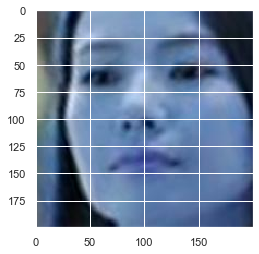

In [41]:
load_model=torch.load('simple_cnn.pt')
loaded_model=model_cpu(load_model)
print_image_prediction(image_path, loaded_model, three_images[0])

Prediction in progress
Predicted Label:  21-30; Female; Indian
Original Label:  21-30; Female; Indian


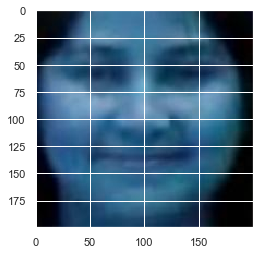

In [42]:
print_image_prediction(image_path, loaded_model, three_images[1])

Prediction in progress
Predicted Label:  21-30; Male; Black
Original Label:  31-40; Female; White


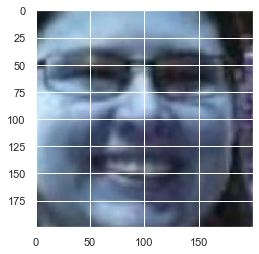

In [43]:
print_image_prediction(image_path, loaded_model, three_images[2])

#### Predicting External Uploaded Images

In [44]:
ext_path='C:\\Users\\jimev\\Desktop\\DeepLearning\\MyProject\\Test_this'

Prediction in progress
Predicted Label:  21-30; Male; Indian


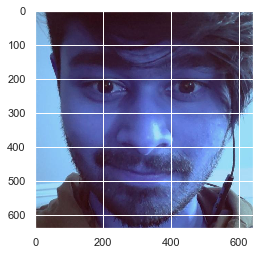

In [45]:
print_image_prediction(ext_path, loaded_model, 'test_4.jpg', original_label=False)

#### The above image is one of our friend, and we are happy that we could predict the labels on his image

#### Model 2 Trials

In [46]:
model_cnn = nn.Sequential(
  nn.Conv2d(C, 32, (3,3), padding=1), 
  nn.MaxPool2d((2,2)),
  nn.Tanh(),
  nn.Conv2d(32, 32, (3,3), padding=1), 
  nn.MaxPool2d((2,2)),
  nn.Tanh(),
  Flatten(), 
  #Why did we reduce the number of units into the Linear layer by a factor of 4? 
  #because pooling a 2x2 grid down to one value means we go from 4 values, down to 1. 
  nn.Linear(32*D//(4**2), classes),
)

In [47]:
model_cnn_results = train_network(model_cnn, loss_func, train_loader, val_loader=test_loader, 
                                   score_funcs={'Accuracy': accuracy_score}, device=device, epochs=10)

In [48]:
model_cnn_results.to_csv('model_cnn_results.csv')
torch.save(model_simple_cnn, 'model_cnn.pt')

Prediction in progress
Predicted Label:  21-30; Female; Asian
Original Label:  21-30; Female; Asian


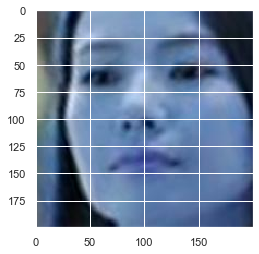

In [49]:
load_model=torch.load('model_cnn.pt')
loaded_model=model_cpu(load_model)
device = torch.device("cuda")
print_image_prediction(image_path, loaded_model, three_images[0])

Prediction in progress
Predicted Label:  21-30; Female; Indian
Original Label:  21-30; Female; Indian


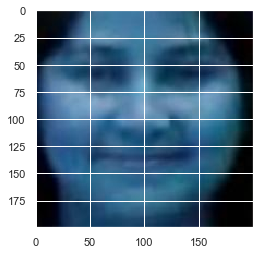

In [50]:
print_image_prediction(image_path, loaded_model, three_images[1])

Prediction in progress
Predicted Label:  21-30; Male; Black
Original Label:  31-40; Female; White


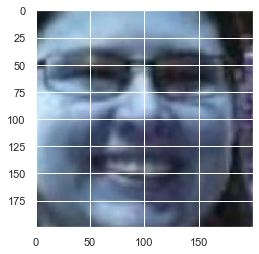

In [51]:
print_image_prediction(image_path, loaded_model, three_images[2])

Prediction in progress
Predicted Label:  21-30; Female; White


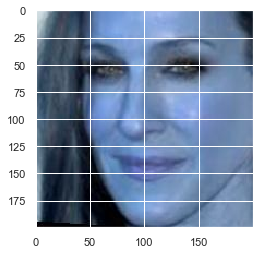

In [52]:
ext_path='C:\\Users\\jimev\\Desktop\\DeepLearning\\MyProject\\Test_this'
print_image_prediction(ext_path, loaded_model, 'test_1.jpg', original_label=False)

#### The above results are using the model_cnn output where the validation accuracy was 26% which were better than the previous results

#### Model 3 Trails


In [53]:
## Trying a fully connected network
model_3 = nn.Sequential(
    Flatten(),
    nn.Linear(3*128*128,128*3*3),
    nn.PReLU(),
    nn.Linear(128*3*3,100*3*3),
    nn.PReLU(),
    nn.Linear(100*3*3,100)

)

In [54]:
model_3_results = train_network(model_3, loss_func, train_loader, val_loader=test_loader, 
                                   score_funcs={'Accuracy': accuracy_score}, device=device, epochs=10)

In [55]:
model_3_results

#### Model 4 Trails

In [56]:
model_4 = nn.Sequential(
    nn.Conv2d(3,64,(3,3),padding=1),
    nn.MaxPool2d((2,2)),
    nn.ELU(),
    nn.Conv2d(64,128,(3,3),padding=1),
    nn.MaxPool2d((2,2)),
    nn.ELU(),
    nn.Conv2d(128,64,(3,3),padding=1),
    nn.MaxPool2d((2,2)),
    nn.ELU(),
    nn.Conv2d(64,32,(3,3),padding=1),
    nn.MaxPool2d((2,2)),
    nn.ELU(),
    
    Flatten(),
    nn.Linear(2048,classes)
)

 Error Message: CUDA out of memory. Tried to allocate 64.00 MiB (GPU 0; 6.00 GiB total capacity; 849.98 MiB already allocated; 10.72 MiB free; 934.00 MiB reserved in total by PyTorch)

Saving model and loading them when needed helped big time

In [57]:
# Got a runtime error of GPU memory running out of allocation
import gc
gc.collect()
# A work around, but din help

18598

In [58]:
model_4_results = train_network(model_4, loss_func, train_loader, val_loader=test_loader, 
                                   score_funcs={'Accuracy': accuracy_score}, device=device, epochs=10)

In [60]:
model_4_results.to_csv('model_4_results.csv')
torch.save(model_4_results, 'model_4.pt')

#### Model 5 Trials

In [62]:
model_5 = nn.Sequential(
    nn.Conv2d(3,64,(3,3),padding=1),
    nn.LeakyReLU(),
    nn.MaxPool2d((2,2)),
    nn.ELU(),
    nn.Conv2d(64,128,(3,3),padding=1),
    nn.LeakyReLU(),
    nn.MaxPool2d((2,2)),
    nn.ELU(),
    nn.Conv2d(128,64,(3,3),padding=1),
    nn.LeakyReLU(),
    nn.MaxPool2d((2,2)),
    nn.ELU(),
    nn.Conv2d(64,32,(3,3),padding=1),
    nn.LeakyReLU(),
    nn.MaxPool2d((2,2)),
    nn.ELU(),
    
    Flatten(),
    nn.Linear(2048,1024),
    nn.Linear(1024, 512),
    nn.Linear(512, 100)
)

In [63]:
model_5_results = train_network(model_5, loss_func, train_loader, val_loader=test_loader, 
                                   score_funcs={'Accuracy': accuracy_score}, device=device, epochs=10)

In [64]:
model_5_results

In [65]:
model_5_results.to_csv('model_5_results.csv')
torch.save(model_5, 'model_5.pt')

In [66]:
# Loading all the dataframes from the saved csv's

In [67]:
simple_cnn_results=pd.read_csv('simple_cnn_results.csv')
model_cnn_results=pd.read_csv('model_cnn_results.csv')
model_3_results=pd.read_csv('model_3_results.csv')
model_4_results=pd.read_csv('model_4_results.csv')
model_5_results=pd.read_csv('model_5_results.csv')

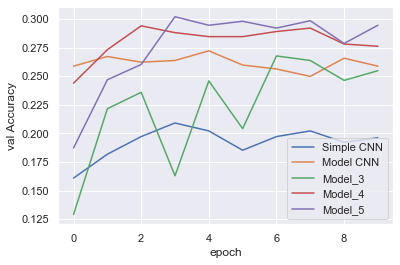

In [68]:
sns.set(rc={'figure.figsize':(6,4)})
sns.lineplot(x='epoch', y='val Accuracy', data=simple_cnn_results, label='Simple CNN')
sns.lineplot(x='epoch', y='val Accuracy', data=model_cnn_results, label='Model CNN')
sns.lineplot(x='epoch', y='val Accuracy', data=model_3_results, label='Model_3')
sns.lineplot(x='epoch', y='val Accuracy', data=model_4_results, label='Model_4')
sns.lineplot(x='epoch', y='val Accuracy', data=model_5_results, label='Model_5')


#### Clearly out of the models that we built, Model_5 had the highest accuracy

#### Picking Model_4, and predicting on files to give labels

In [69]:
random.shuffle(train)
three_images=[]
for i in range(3): three_images.append(train[i])

Prediction in progress
Predicted Label:  61-70; Female; White
Original Label:  70+; Female; White


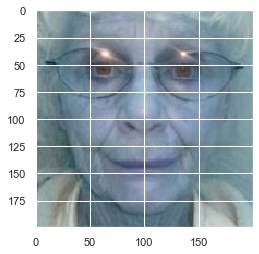

In [70]:
load_model=torch.load('model_3.pt')
loaded_model=model_cpu(load_model)
device = torch.device("cuda")
print_image_prediction(image_path, loaded_model, three_images[0])

Prediction in progress
Predicted Label:  21-30; Male; White
Original Label:  31-40; Male; Hispanic/Latino/Middle Eastern


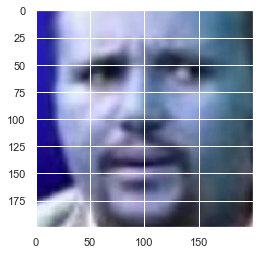

In [71]:
print_image_prediction(image_path, loaded_model, three_images[1])

Prediction in progress
Predicted Label:  16-20; Female; Indian
Original Label:  21-30; Female; Indian


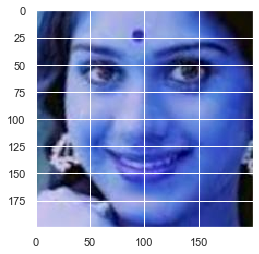

In [72]:
print_image_prediction(image_path, loaded_model, three_images[2])

#### Predicting final model on external images

Prediction in progress
Predicted Label:  31-40; Male; Black


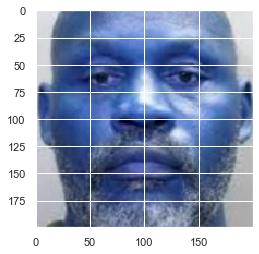

In [73]:
ext_path='C:\\Users\\jimev\\Desktop\\DeepLearning\\MyProject\\Test_this'
print_image_prediction(ext_path, loaded_model, 'test_2.jpg', original_label=False)

Prediction in progress
Predicted Label:  70+; Male; White


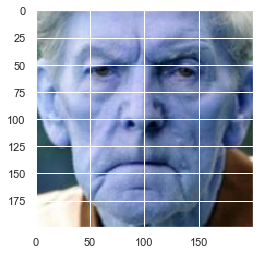

In [74]:
print_image_prediction(ext_path, loaded_model, 'test_3.jpg', original_label=False)

Prediction in progress
Predicted Label:  0-5; Female; Asian


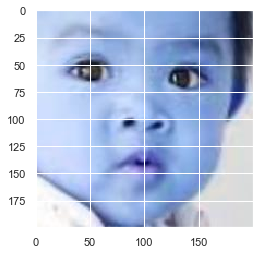

In [75]:
print_image_prediction(ext_path, loaded_model, 'test_5.jpeg', original_label=False)

#### Conclusions:

 - The main reason which we think of for the results not being great is creating our own labelling
 - We are also not sure on how many images we have for each class
 - We may have run into class imbalance problem

#### Possible Enhancements:
 - We initially thought of generating images adding old filters-- Meaning, input image would be an young image and the model had to generate an image of the same person on how possibly he would look old.
 - This goal was tried using GAN, but we could not reach atleast 50%, so we stuck our project to classification of the age, gender and Ethnicity
 
